## Initializing

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [3]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('mehradaria/covid19-lung-ct-scans', path="/content/", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans


In [69]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from PIL import Image, ImageOps
import math
from PIL import Image, ImageOps

In [5]:
# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [6]:
# Configuration
IMAGE_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 10
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)

## Required functions

In [51]:
def create_data_generators(img_dir):
    """
    Create train and validation data generators.

    Args:
        img_dir (str): Directory containing the image data.

    Returns:
        tuple: Train and validation data generators, and steps per epoch.
    """
    data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    print("Preparing training data:")
    train_gen = data_gen.flow_from_directory(
        img_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode="grayscale",
        class_mode="binary",
        subset="training"
    )

    print("Preparing validation data:")
    val_gen = data_gen.flow_from_directory(
        img_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode="grayscale",
        class_mode="binary",
        subset="validation"
    )

    # Calculate steps per epoch
    train_steps = math.ceil(train_gen.samples / BATCH_SIZE)
    val_steps = math.ceil(val_gen.samples / BATCH_SIZE)

    return train_gen, val_gen, train_steps, val_steps

In [45]:
# Model definition
def create_model():
    """
    Create and compile the CNN model.

    Returns:
        tf.keras.Model: Compiled model.
    """
    inputs = keras.Input(shape=INPUT_SHAPE)
    x = layers.Conv2D(16, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [55]:
# Custom training loop
def train_model(model, train_gen, val_gen, train_steps, val_steps):
    """
    Train the model using a custom training loop.

    Args:
        model (tf.keras.Model): Model to train.
        train_gen (tf.keras.preprocessing.image.DirectoryIterator): Training data generator.
        val_gen (tf.keras.preprocessing.image.DirectoryIterator): Validation data generator.
        train_steps (int): Number of steps per epoch for training.
        val_steps (int): Number of steps per epoch for validation.

    Returns:
        dict: Training history.
    """
    optimizer = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.BinaryCrossentropy()

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        return loss_value, logits

    @tf.function
    def test_step(x, y):
        val_logits = model(x, training=False)
        return loss_fn(y, val_logits), val_logits

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        progbar = tf.keras.utils.Progbar(train_steps, stateful_metrics=['loss'])

        # Create new metric instances for each epoch
        train_acc_metric = tf.keras.metrics.BinaryAccuracy()
        val_acc_metric = tf.keras.metrics.BinaryAccuracy()

        # Training loop
        for step in range(train_steps):
            x_batch, y_batch = next(train_gen)
            loss_value, logits = train_step(x_batch, y_batch)
            train_acc_metric.update_state(y_batch, logits)
            progbar.update(step+1, values=[('loss', loss_value.numpy())])

        train_acc = train_acc_metric.result()
        print(f"Training Accuracy: {train_acc:.4f}")

        # Validation loop
        val_losses = []
        for step in range(val_steps):
            x_batch, y_batch = next(val_gen)
            val_loss, val_logits = test_step(x_batch, y_batch)
            val_acc_metric.update_state(y_batch, val_logits)
            val_losses.append(val_loss)

        val_acc = val_acc_metric.result()
        val_loss = tf.reduce_mean(val_losses)
        print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

        # Update history
        history['loss'].append(loss_value.numpy())
        history['accuracy'].append(train_acc.numpy())
        history['val_loss'].append(val_loss.numpy())
        history['val_accuracy'].append(val_acc.numpy())

        # Reset generators
        train_gen.reset()
        val_gen.reset()

    return history

In [32]:
# Evaluation function
def evaluate_model(model, val_gen):
    """
    Evaluate the model and print metrics.

    Args:
        model (tf.keras.Model): Trained model.
        val_gen (tf.keras.preprocessing.image.DirectoryIterator): Validation data generator.
    """
    y_pred = model.predict(val_gen)
    y_pred = (y_pred > 0.5).astype(int)
    y_true = val_gen.classes

    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [59]:
def plot_history(history):
    """
    Plot training and validation accuracy and loss.

    Args:
        history (dict): Training history.
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [65]:
# Prediction function
def predict_image(model, image_path):
    """
    Predict whether an image contains COVID-19 or not.

    Args:
        model (tf.keras.Model): Trained model.
        image_path (str): Path to the image file.
    """
    image = Image.open(image_path)
    image = ImageOps.grayscale(image)
    image = ImageOps.fit(image, (IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.LANCZOS)
    image_array = np.asarray(image)
    data = image_array.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, 1)) / 255

    prediction = model.predict(data)[0][0]
    result = "COVID detected" if prediction > 0.5 else "No COVID detected"

    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction: {result}")
    plt.show()
    print(f"Prediction: {result} (Probability: {prediction:.4f})")

## Creating dataset

In [53]:
img_dir = '/content/COVID-19_Lung_CT_Scans'
train_gen, val_gen, train_steps, val_steps = create_data_generators(img_dir)

Preparing training data:
Found 6752 images belonging to 2 classes.
Preparing validation data:
Found 1687 images belonging to 2 classes.


## Compiling model



In [36]:
model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 61, 61, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 311,793 (1.19 MB)

 Trainable params: 311,793 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

## Training models

In [56]:
historyhistory = None

In [57]:
history = train_model(model, train_gen, val_gen, train_steps, val_steps)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 515ms/step - loss: 0.2277
Training Accuracy: 0.9403
Validation Accuracy: 0.8992, Validation Loss: 0.2944

Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 504ms/step - loss: 0.0779
Training Accuracy: 0.9544
Validation Accuracy: 0.9152, Validation Loss: 0.2271

Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 504ms/step - loss: 0.1545
Training Accuracy: 0.9624
Validation Accuracy: 0.9229, Validation Loss: 0.2789

Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - loss: 0.0815
Training Accuracy: 0.9665
Validation Accuracy: 0.9301, Validation Loss: 0.2277

Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 503ms/step - loss: 0.0718
Training Accuracy: 0.9686
Validation Accuracy: 0.9265, Validation Loss: 0.2057

Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - loss: 0.0528
Training Accuracy: 0.9705
Validation Accuracy: 0.9384, Validation Loss: 0.1980

Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - loss: 0.0910
Training Accuracy: 0.9739
Validation Accura

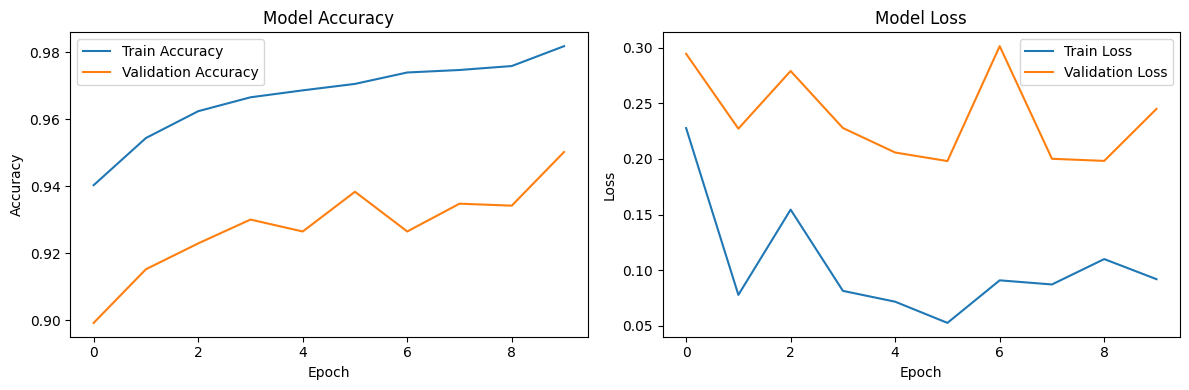

In [60]:
plot_history(history)

## Evaluating

14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 498ms/step
Accuracy: 0.8074
Precision: 0.1040
Recall: 0.0957
F1-score: 0.0997


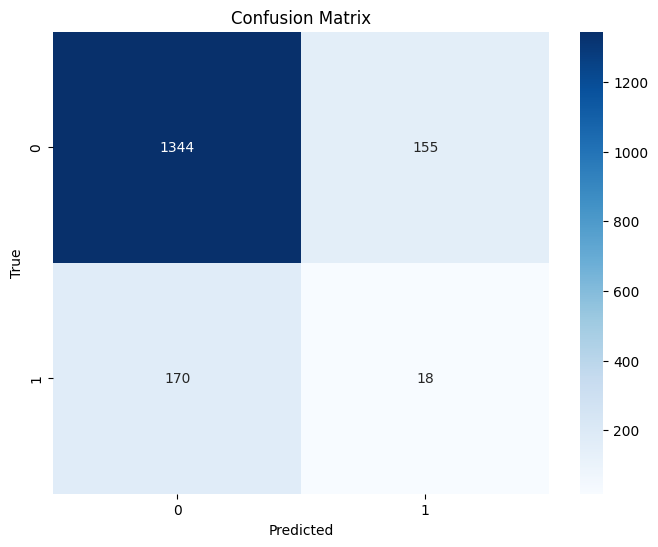

In [61]:
evaluate_model(model, val_gen)

In [62]:
# Save the model
model.save('/content/drive/MyDrive/ML/covid 19 detection/CovidTest.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


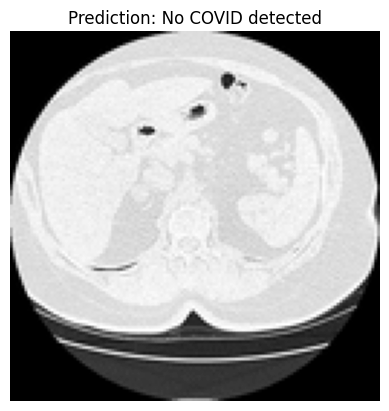

Prediction: No COVID detected (Probability: 0.0139)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


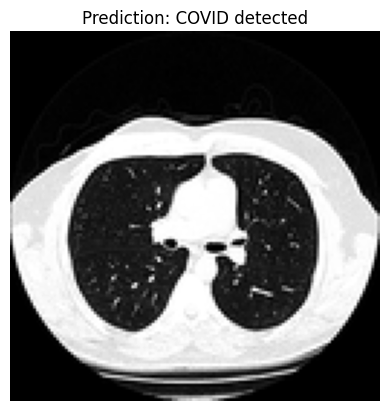

Prediction: COVID detected (Probability: 0.9990)


In [68]:
# Example prediction
predict_image(model, '/content/COVID-19_Lung_CT_Scans/COVID-19/COVID-19_0231.png')
predict_image(model, '/content/COVID-19_Lung_CT_Scans/Non-COVID-19/Non-COVID-19_251.png')